In [1]:
import scanpy as sc
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
import statsmodels as sm
import anndata as ad
from datetime import datetime
from scipy import sparse
import plotly.express as px
from adjustText import adjust_text
import sys
import os
from tqdm import tqdm
import importlib
import gseapy as gp
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # to edit text in Illustrator

paper_path = "/mnt/x/Common/Lab_Papers/shedding_potential/"
figure_path = paper_path+"/fig2/"
utils_path = paper_path + "utils/"
os.chdir(utils_path)
import shed_funcs

np.random.seed(6)

# this is not critical for the analysis
LOAD_ARIAL = True
if LOAD_ARIAL:
    # set the default font to Arial
    from matplotlib.font_manager import FontProperties, fontManager
    from matplotlib import rcParams
    # Path to Arial font
    arial_path = utils_path+'/Arial.ttf'

    # Define font properties with the specific path
    arial_font = FontProperties(fname=arial_path)
    fontManager.addfont(arial_path)

    # Set the font as the default for all text elements
    rcParams['font.family'] = arial_font.get_family()
    rcParams['font.sans-serif'] = [arial_font.get_name()]

## Load Keren's mice data and calculate shedding residuals

In [2]:
df = sc.read_csv(figure_path+'keren_mouse_data.csv')
df = df.T
df

mdata = sc.AnnData(df)
# split mdata.obs_names into segment,type and name
mdata.obs['mouse'] = mdata.obs_names.str.split('-').str[1].str.lower()
mdata.obs['segment'] = mdata.obs_names.str.split('-').str[2].str.lower()
mdata.obs['type'] = mdata.obs_names.str.split('-').str[3].str.lower()

sample_type_dict = {'f': 'wash', 't': 'biopsy'}
mdata.obs['type'] = mdata.obs['type'].map(sample_type_dict)

mdata.layers['counts'] = mdata.X.copy()
mdata.layers['mat_norm'] = sc.pp.normalize_total(mdata, target_sum=1, inplace=False,exclude_highly_expressed=True, max_fraction=0.1)['X']
mdata.layers['log_norm'] = sc.pp.log1p(sc.pp.normalize_total(mdata, target_sum=10000, inplace=False,exclude_highly_expressed=True, max_fraction=0.1)['X'], copy=True)
mdata.layers['log_zscore'] = mdata.layers['log_norm'].copy()
mdata.X = mdata.layers['log_zscore'].copy()
sc.pp.scale(mdata, layer='log_zscore', max_value=10)
# mdata.layers['log_zscore'] = mdata.layers['log_zscore'] + np.abs(np.min(mdata.layers['log_zscore'])) + 1


In [3]:
# keep only jejunum
print(mdata.shape)
mdata = mdata[mdata.obs['segment'] == 'jej']
print(mdata.shape)

(87, 17891)
(18, 17891)


Correlation: 0.9549906702348889, p-value: 0.0


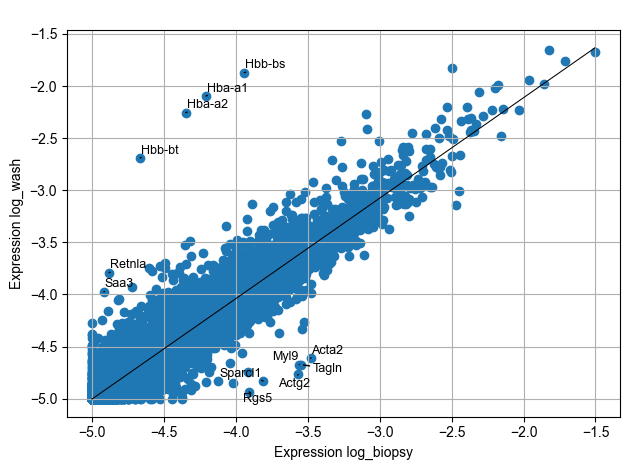

In [4]:
importlib.reload(shed_funcs)
# mdata.layers['max_norm'] = mdata.layers['mat_norm']/mdata.layers['mat_norm'].max(axis=0)

# resids = shed_funcs.calc_resids_by_field(mdata, "type", "biopsy", "wash", RESID_THRESH=0.9, title=" ",layer='max_norm')
USE_LOG = False
resids = shed_funcs.calc_resids_by_field(mdata, "type", "biopsy", "wash", RESID_THRESH=0.9, title=" ",layer='mat_norm', )

In [5]:
biopsy_str = "log_biopsy"
wash_str = "log_wash"

px.scatter(resids, x=biopsy_str, y=wash_str, color='residual', hover_name=resids.index)

Correlation: 0.9549906702348889, p-value: 0.000000e+00
Manually evaluating minimal p-value:
p < 1e-323


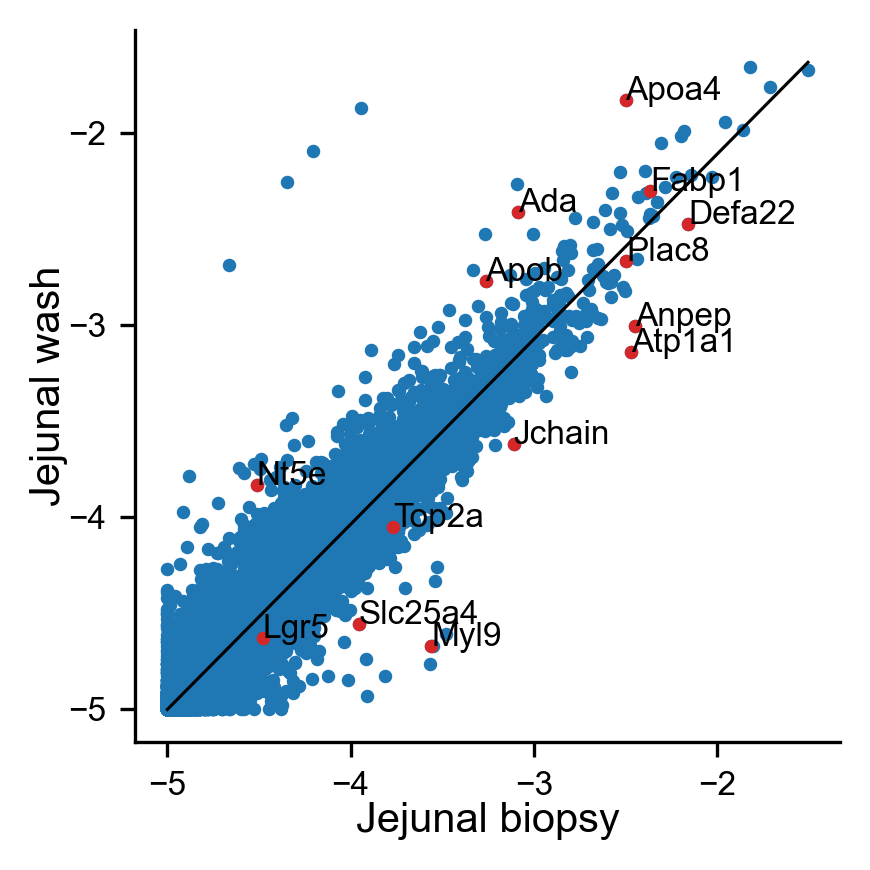

exporting


In [6]:
importlib.reload(shed_funcs)
highlight_genes = ['Ada','Nt5e','Apoa4','Myl9','Apob','Atp1a1','Top2a',"Fabp1","Plac8","Lgr5","Slc25a4","Anpep","Defa22","Jchain"]
# the use in USE_LOG should be consistent between this and the previous function
shed_funcs.plot_tissue_shed_for_fig(resids, highlight_genes,
                                    fontsize=8, figsize=(3,3),spot_size=5, add_arrows=False, reg_line_width=0.75,
                                    exp_path=figure_path+"fig2a.pdf", my_xlabel="Jejunal biopsy", my_ylabel="Jejunal wash", 
                                     white_outline_width=0, use_adjust_text=False)

In [7]:
resids.loc[np.intersect1d(highlight_genes,resids.index)]

biopsy      wash  log_biopsy  log_wash  residual
Ada      0.000806  0.003853   -3.088189 -2.413093  0.747472
Anpep    0.003573  0.000977   -2.445753 -3.005702 -0.464344
Apoa4    0.003154  0.014811   -2.499799 -1.829135  0.764314
Apob     0.000535  0.001674   -3.263871 -2.773623  0.556273
Atp1a1   0.003367  0.000714   -2.471408 -3.139981 -0.573896
Defa22   0.006939  0.003335   -2.158062 -2.475663 -0.211594
Fabp1    0.004282  0.004947   -2.367353 -2.304768  0.161025
Jchain   0.000765  0.000230   -3.110503 -3.620147 -0.438075
Lgr5     0.000023  0.000013   -4.479631 -4.632709 -0.131011
Myl9     0.000266  0.000011   -3.559570 -4.672771 -1.057868
Nt5e     0.000021  0.000137   -4.511455 -3.834130  0.698240
Plac8    0.003183  0.002138   -2.495764 -2.667946 -0.078385
Slc25a4  0.000101  0.000018   -3.955531 -4.557070 -0.560523
Top2a    0.000160  0.000079   -3.768367 -4.050789 -0.234638

## Load single cell data - Moor

In [8]:
moor_data_path =  figure_path+'table_B_scRNAseq_UMI_counts.tsv'
moor_data = pd.read_csv(moor_data_path, index_col=0, sep='\t')
moor_data = moor_data.T
print(moor_data.shape)
moor_data.head()

(1383, 27998)


gene              Xkr4  Gm1992  Gm37381  Rp1  Rp1.1  Sox17  Gm37323  Mrpl15  \
AAACCTGGTAAGTTCC     0       0        0    0      0      0        0       0   
AAACGGGCACCAACCG     0       0        0    0      0      0        0       0   
AAACGGGTCACTGGGC     0       0        0    0      0      0        0       0   
AAAGATGGTGGACGAT     0       0        0    0      0      0        0       0   
AAAGATGGTTCGGGCT     0       0        0    0      0      0        0       2   

gene              Lypla1  Gm37988  ...  AC125149.1  AC125149.2  AC125149.4  \
AAACCTGGTAAGTTCC       1        0  ...           0           0           0   
AAACGGGCACCAACCG       2        0  ...           0           0           0   
AAACGGGTCACTGGGC       2        0  ...           0           0           0   
AAAGATGGTGGACGAT       4        0  ...           0           0           0   
AAAGATGGTTCGGGCT       1        0  ...           0           0           0   

gene              AC234645.1  AC168977.2  AC168977.1  PISD  DHRSX  Vmn2r122  \
AAACCTGGTAAGTTCC           0           0           0     0      1         0   
AAACGGGCACCAACCG           0           0           0     0      0         0   
AAACGGGTCACTGGGC           0           0           0     1      2         0   
AAAGATGGTGGACGAT           0           0           0     0      0         0   
AAAGATGGTTCGGGCT           0           0           0     1      0         0   

gene              CAAA01147332.1  
AAACCTGGTAAGTTCC               0  
AAACGGGCACCAACCG               0  
AAACGGGTCACTGGGC               0  
AAAGATGGTGGACGAT               0  
AAAGATGGTTCGGGCT               0  

[5 rows x 27998 columns]

In [9]:
moor_zones_path = figure_path+'table_C_scRNAseq_tsne_coordinates_zones.tsv'
moor_zones = pd.read_csv(moor_zones_path, index_col=0, sep='\t')
print(moor_zones.shape)
moor_zones.head()

(1383, 3)


tSNE_coordinate_1  tSNE_coordinate_2 zone
cell_id                                                    
AAACCTGGTAAGTTCC          12.518369         -16.735935   V3
AAACGGGCACCAACCG          -3.619842          -5.642620   V5
AAACGGGTCACTGGGC          13.622892          16.828087   V1
AAAGATGGTGGACGAT          15.653014           3.311508   V2
AAAGATGGTTCGGGCT           6.754220          20.791256   V1

In [10]:
# merge both into anndata
moor_adata = sc.AnnData(moor_data)
moor_adata.obs = moor_zones.loc[moor_adata.obs_names]

# normalize
moor_adata.layers['counts'] = moor_adata.X.copy()
moor_adata.layers['mat_norm'] = sc.pp.normalize_total(moor_adata, target_sum=1, inplace=False, exclude_highly_expressed=True, max_fraction=0.1)['X']
moor_adata.layers['log_norm'] = sc.pp.log1p(sc.pp.normalize_total(moor_adata, target_sum=10000, inplace=False,exclude_highly_expressed=True, max_fraction=0.1)['X'], copy=True)

moor_adata.obsm['X_tsne'] = moor_adata.obs[['tSNE_coordinate_1','tSNE_coordinate_2']].values
print(moor_adata.shape)
moor_adata

(1383, 27998)


AnnData object with n_obs × n_vars = 1383 × 27998
    obs: 'tSNE_coordinate_1', 'tSNE_coordinate_2', 'zone'
    obsm: 'X_tsne'
    layers: 'counts', 'mat_norm', 'log_norm'

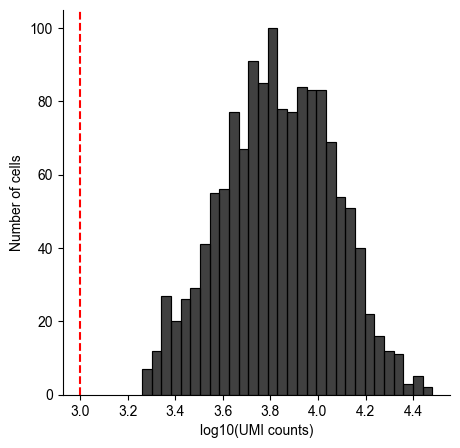

In [11]:
# add histogram of UMI counts
moor_adata.obs['UMI_counts'] = moor_adata.X.sum(axis=1)
moor_adata.obs['log10_umi_counts'] = np.log10(moor_adata.obs['UMI_counts'])

# add line at UMI_THRESH
UMI_THRESH = 1000

# add histogram
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(moor_adata.obs['log10_umi_counts'], bins=30, color='black', ax=ax)
ax.axvline(np.log10(UMI_THRESH), color='red', linestyle='--')
ax.set_xlabel('log10(UMI counts)')
ax.set_ylabel('Number of cells')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [12]:
# filter according to UMI_THRESH
print(moor_adata.shape)
moor_adata = moor_adata[moor_adata.obs['UMI_counts'] > UMI_THRESH]
print(moor_adata.shape)

(1383, 27998)
(1383, 27998)


In [13]:
# add shedding scores
print(resids.shape)
intersect_genes = np.intersect1d(resids.index, moor_adata.var_names)
shedding_resids = resids.loc[intersect_genes]
print(resids.shape)

moor_adata.obs['shedding_score'] = None
moor_adata.var['shedding_residual'] = None
moor_adata.var.loc[shedding_resids.index, 'shedding_residual']= shedding_resids['residual']

tmp_ad = moor_adata[:,shedding_resids.index].copy()
# tmp_ad.X = tmp_ad.layers['mat_norm']
sc.pp.normalize_total(tmp_ad, target_sum=1, exclude_highly_expressed=True, max_fraction=0.1)

print(tmp_ad.shape)

resids_vals = np.array(tmp_ad.var['shedding_residual'])
resids_vals = np.expand_dims(resids_vals, axis=1)
resids_matnorm = tmp_ad.layers['mat_norm']

shedding_scores = resids_matnorm @ resids_vals # This line is critical

tmp_ad.obs['shedding_score'] = np.squeeze(np.array(shedding_scores))

# send back the shedding score from the tmp_ad to the adata
moor_adata.obs.loc[tmp_ad.obs.index, 'shedding_score'] = tmp_ad.obs.loc[tmp_ad.obs.index, 'shedding_score']
moor_adata.obs['shedding_score'] = pd.to_numeric(moor_adata.obs['shedding_score'], errors='coerce')

(17891, 5)
(17891, 5)
(1383, 17891)


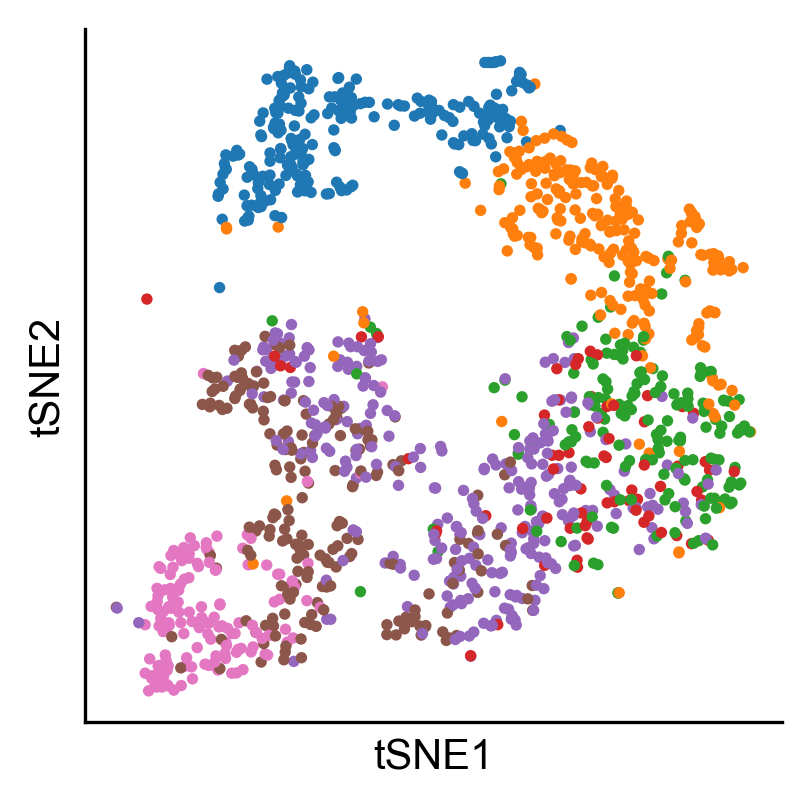

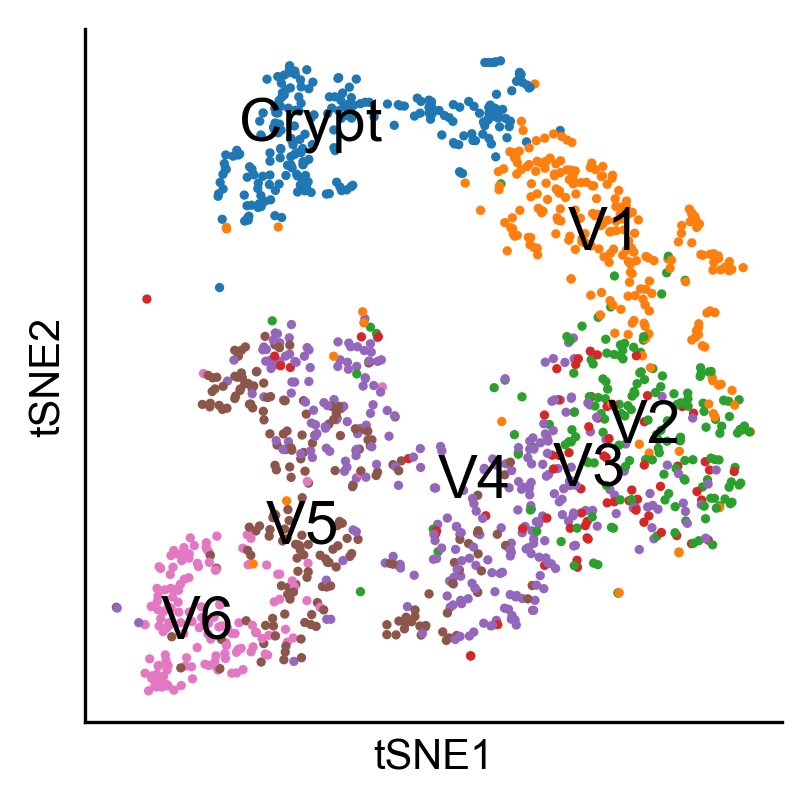

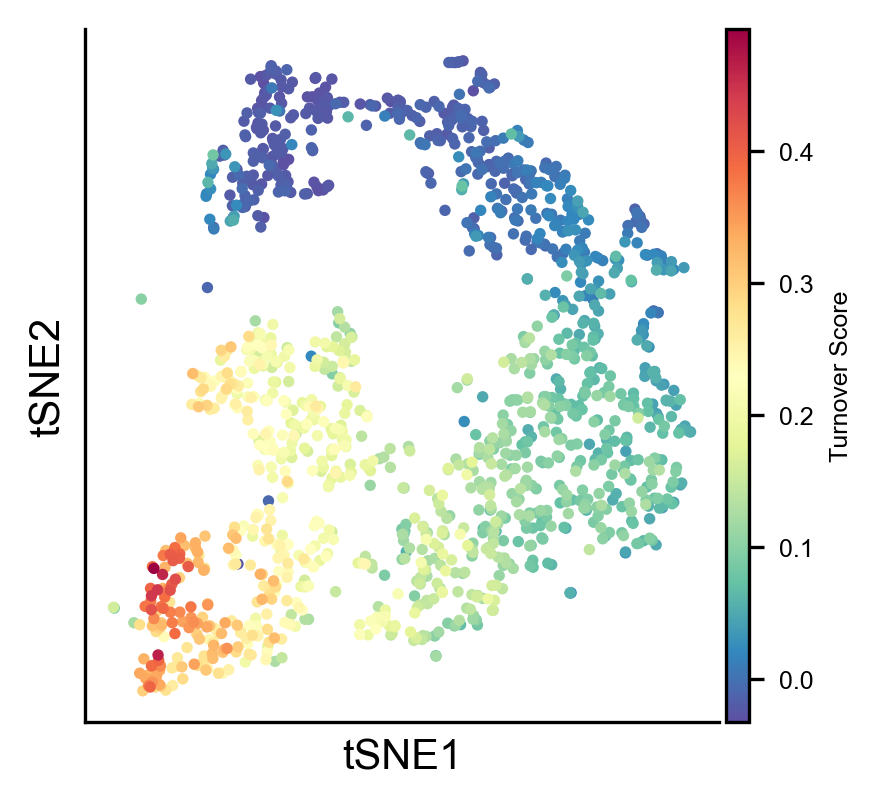

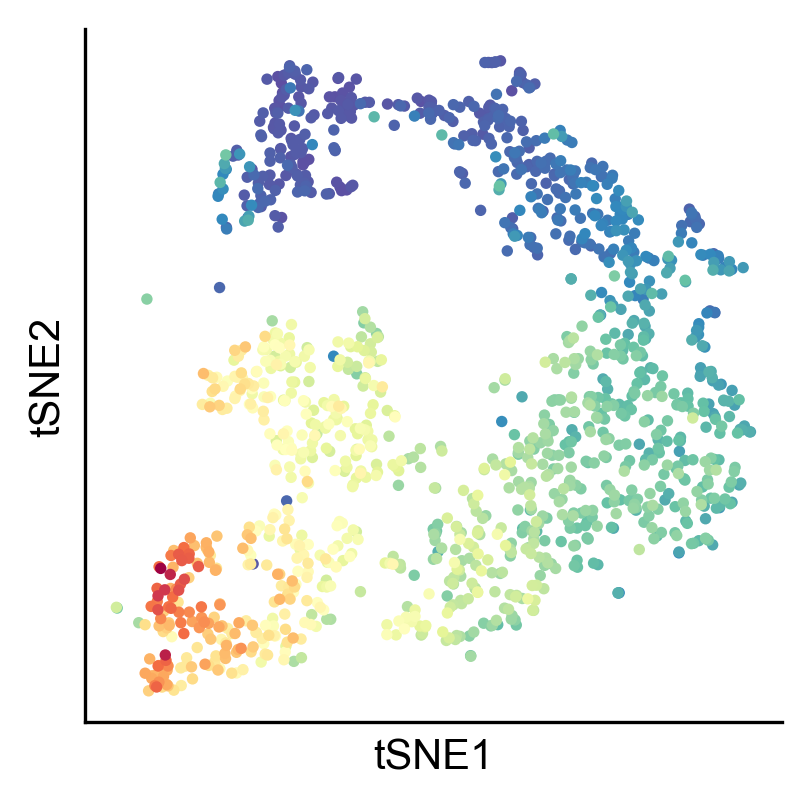

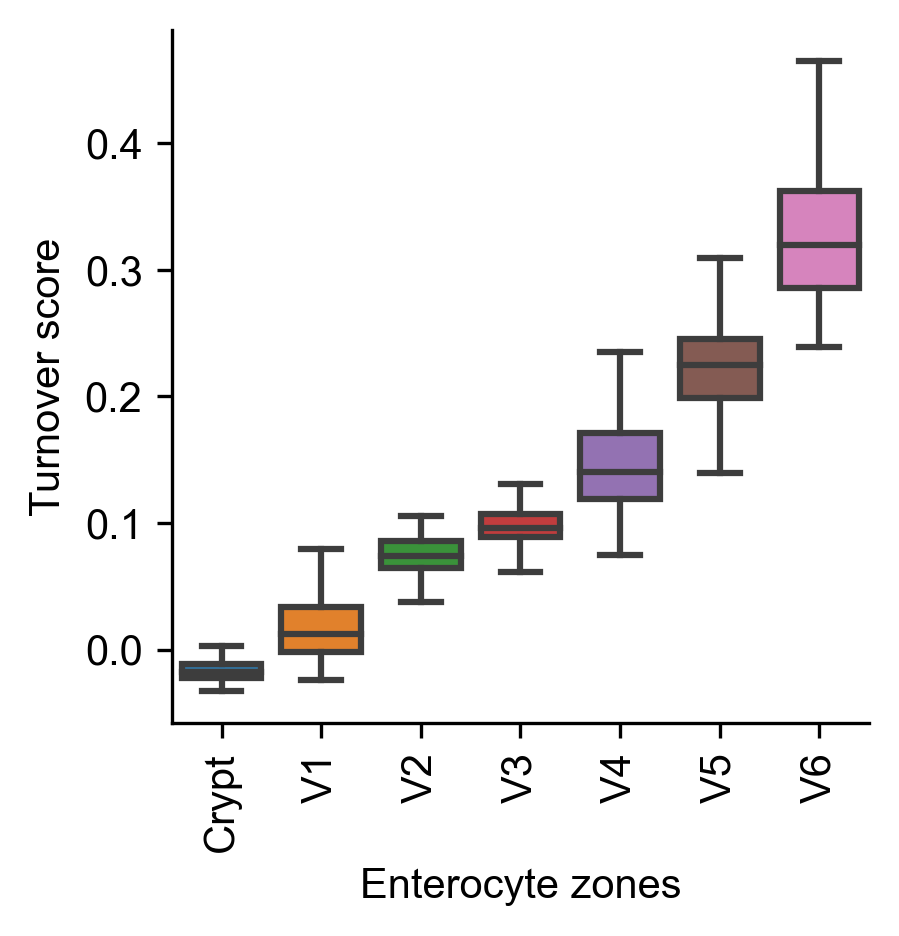

In [14]:
my_fig_size = (3,3)
SPOT_SIZE = 30

fig, ax = plt.subplots(1, 1, figsize=my_fig_size, dpi=300)
sc.pl.tsne(moor_adata, color=['zone'], legend_loc='none', ax=ax, show=False, size=SPOT_SIZE,palette=None)#palette=sns.color_palette("husl", 7)
sns.despine(ax=ax, top=True, right=True)
ax.set_title('')
plt.show()
fig.savefig(figure_path+"fig2b_no_text.pdf", bbox_inches='tight')

LEGEND_OUTLINE = 0
fig, ax = plt.subplots(1, 1, figsize=my_fig_size, dpi=300)
if LEGEND_OUTLINE > 0:
    sc.pl.tsne(moor_adata, color=['zone'], legend_loc='on data', legend_fontsize='x-large', legend_fontoutline=LEGEND_OUTLINE, ax=ax, show=False, size=20) # sns.color_palette("husl", 7)
else:
    sc.pl.tsne(moor_adata, color=['zone'], legend_loc='on data', legend_fontsize='x-large', ax=ax, show=False, size=20) # sns.color_palette("husl", 7)
sns.despine(ax=ax, top=True, right=True)
ax.set_title('')
plt.show()
fig.savefig(figure_path+"fig2b.pdf", bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=my_fig_size, dpi=300)
sc.pl.tsne(moor_adata, color=['shedding_score'], cmap='Spectral_r',ax=ax, show=False, size=SPOT_SIZE)
sns.despine(ax=ax, top=True, right=True)
ax.set_title('')
cbar = ax.collections[0].colorbar
cbar.set_label('Turnover Score', fontsize=6)
cbar.ax.tick_params(labelsize=6)
plt.show()
fig.savefig(figure_path+"fig2d_w_legend.pdf", bbox_inches='tight')


fig, ax = plt.subplots(1, 1, figsize=my_fig_size, dpi=300)
sc.pl.tsne(moor_adata, color=['shedding_score'], ax=ax, cmap='Spectral_r',show=False, size=SPOT_SIZE, colorbar_loc=None)
sns.despine(ax=ax, top=True, right=True)
ax.set_title('')
plt.show()
fig.savefig(figure_path+"fig2d_wo_legend.pdf", bbox_inches='tight')

# Calculate the median shedding score for each group
group_medians = moor_adata.obs.groupby("zone")["shedding_score"].median()

# Sort the groups by the median shedding score
sorted_groups = group_medians.sort_values().index

# Plot the violin plot with the groups ordered by the median shedding score
fig, ax = plt.subplots(1, 1, figsize=my_fig_size, dpi=300)
# sc.pl.violin(moor_adata, inner="box", keys=["shedding_score"], groupby="zone", rotation=90,
#               order=sorted_groups, xlabel="Enterocyte zones", ylabel="Shedding score", ax=ax, show=False,
#               stripplot=False)
sns.boxplot(moor_adata.obs, y="shedding_score", x="zone",
              order=sorted_groups, ax=ax, showfliers=False, palette='tab10')
plt.xticks(rotation=90)
plt.xlabel("Enterocyte zones")
plt.ylabel("Turnover score")
# plt.axhline(0, color='black', linestyle='--', zorder=0)
sns.despine(ax=ax, top=True, right=True)
plt.show()
fig.savefig(figure_path+"fig2e.pdf", bbox_inches='tight')

In [15]:
print(datetime.now())

2025-05-07 17:36:55.308161
